In [43]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import string 
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import pickle

train.csv shape is  (447583, 11)
test.csv shape is  (80000, 2)

   id             reviewerID  album_mbid  \
0   1   A0001624UKLQG4OFIM8X  B000002KIC   
1   2  A00082583JGF0RURTDN8A  B000007T1M   
2   3  A00162161QSZVJYMHX0T4  B0000001T0   
3   4  A00162161QSZVJYMHX0T4  B0000001UU   
4   5  A00162161QSZVJYMHX0T4  B0000001SB   

                            artist_mbid  unixReviewTime  VotedHelpful  \
0  8c90ad8c-9150-4c51-a1eb-342232e99d06      1361059200             0   
1  cc0b7089-c08d-4c10-b6b0-873582c17fd6      1393632000             0   
2  f1f81989-dfa9-4bd3-805e-dcf3900c43e3      1402358400             0   
3  0c361ea5-98c6-4947-900b-201833f2dd84      1402358400             0   
4  f1f81989-dfa9-4bd3-805e-dcf3900c43e3      1402358400             0   

   TotalVotes                            summary  \
0           0                very good listening   
1           0                Best album ever!!!!   
2           0        A great Album , good seller   
3           0  Larry and

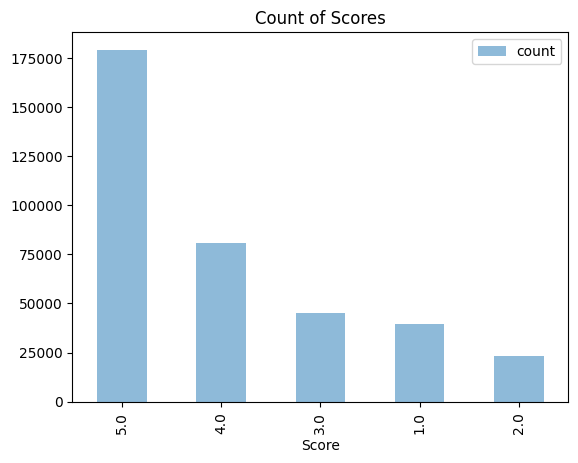

In [44]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")
trainingSetSample = trainingSet.sample(frac=0.25, random_state=42)

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

In [48]:
# Want to print the review distribution for each score 1-5 for a set of random product ids
# Randomly select 5 product ids
product_ids = trainingSet['album_mbid'].sample(10).tolist()
# Print the number of each 1-5 star reviews for each product id
for product_id in product_ids:
    print("Product ID:", product_id, "\n", trainingSet[trainingSet['album_mbid'] == product_id]['Score'].value_counts())

# Sample 10 2 star reviews and print the most commonly used words
sample_2_star_reviews = trainingSet[trainingSet['Score'] == 2].sample(50)
print("Sample 2 Star Reviews:")
for index, row in sample_2_star_reviews.iterrows():
    print("Review:", row['reviewText'])
    print("Most Common Words:", pd.Series(row['reviewText'].split()).value_counts().head(5))
    print()

# Sample 10 1 star reviews and print the most commonly used words that are not linking verbs
sample_1_star_reviews = trainingSet[trainingSet['Score'] == 1].sample(50)
print("Sample 2 Star Reviews:")
for index, row in sample_1_star_reviews.iterrows():
    print("Review:", row['reviewText'])
    print("Most Common Words:", pd.Series(row['reviewText'].split()).value_counts().head(5))
    print()

# Print average length of a 1 star review in a sample of 5000
sample_1_star_reviews = trainingSet[trainingSet['Score'] == 1].sample(5000, random_state=42)
average_length = sample_1_star_reviews['reviewText'].apply(lambda x: len(x.split())).mean()
print("Average length of a 1 star review:", average_length)

# Print average length of a 5 star review in a sample of 5000
sample_5_star_reviews = trainingSet[trainingSet['Score'] == 5].sample(5000, random_state=42)
average_length = sample_5_star_reviews['reviewText'].apply(lambda x: len(x.split())).mean()
print("Average length of a 5 star review:", average_length)
 
# Print average length of a 2 star review in a sample of 5000
sample_2_star_reviews = trainingSet[trainingSet['Score'] == 2].sample(5000, random_state=42)
average_length = sample_2_star_reviews['reviewText'].apply(lambda x: len(x.split())).mean()
print("Average length of a 2 star review:", average_length)

# Results show a weak correlation between review sentiment and length of review


Product ID: B0026T4RTI 
 Score
4.0    9
1.0    5
3.0    4
2.0    3
5.0    2
Name: count, dtype: int64
Product ID: B0009YNSG0 
 Score
5.0    28
4.0    27
3.0    11
2.0     9
1.0     5
Name: count, dtype: int64
Product ID: B000009Q3L 
 Score
5.0    5
4.0    5
1.0    2
Name: count, dtype: int64
Product ID: B009F6RF9Y 
 Score
5.0    93
4.0    12
1.0    12
3.0     5
2.0     4
Name: count, dtype: int64
Product ID: B00006F83Y 
 Score
4.0    121
5.0     83
3.0     62
1.0     31
2.0     13
Name: count, dtype: int64
Product ID: B000009VOL 
 Score
5.0    16
4.0     5
2.0     3
1.0     3
3.0     3
Name: count, dtype: int64
Product ID: B000N3ST8E 
 Score
5.0    17
4.0     2
3.0     2
Name: count, dtype: int64
Product ID: B00000012X 
 Score
5.0    12
4.0     5
1.0     3
3.0     1
2.0     1
Name: count, dtype: int64
Product ID: B000VJ6I4C 
 Score
1.0    6
3.0    4
5.0    2
4.0    2
2.0    1
Name: count, dtype: int64
Product ID: B00006ALCK 
 Score
5.0    141
4.0     26
2.0     12
1.0      7
3.0      6

In [49]:
#take a sample from trainingset
trainingSetSamp = trainingSetSample[trainingSetSample["Score"].notnull()]
# Looking to classify words as positive or negative within the review's body (-1,1)
trainingSetSamp["Total"] = trainingSetSamp["summary"].fillna("") + " " + trainingSetSamp["summary"].fillna("") + " " + trainingSetSamp["reviewText"].fillna("") 

trainingSetSamp = trainingSetSamp[trainingSetSamp["Score"].notnull()]

# Looking to retrieve lengths of each body
#trainingSetSamp["BodyLength"] = trainingSetSamp["Total"].apply(lambda x: len(x.split()))

trainingSetSamp["Polarity"] = trainingSetSamp["Total"].apply(lambda x: TextBlob(x).sentiment.polarity)
trainingSetSamp["Exclaim"] = trainingSetSamp["Total"].apply(lambda x: x.count('!'))
trainingSetSamp["Question"] = trainingSetSamp["Total"].apply(lambda x: x.count('?'))
trainingSetSamp["PolarExc"] = trainingSetSamp["Polarity"] * trainingSetSamp["Exclaim"]
trainingSetSamp["PolarQues"] = trainingSetSamp["Polarity"] * trainingSetSamp["Question"]



meta_features = trainingSetSamp[["PolarExc", "PolarQues"]].fillna(0).values

XmetaSparse = csr_matrix(meta_features)
Vectorizer = TfidfVectorizer(max_features=50000, stop_words='english', ngram_range=(1,2))
XComb = Vectorizer.fit_transform(trainingSetSamp["Total"])

Xtotal = hstack([XComb, XmetaSparse])

nonNull = trainingSetSamp["Score"].notnull().to_numpy()
X = Xtotal[nonNull]
Y = trainingSetSamp.loc[nonNull, "Score"].astype(int)

with open("VecBodyPolar.pkl", "wb") as f:
    pickle.dump(Vectorizer, f)




/var/folders/mj/kb1qg2zn7d9ghdtz0qgm4hzh0000gn/T/ipykernel_21789/395012508.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingSetSamp["Total"] = trainingSetSamp["summary"].fillna("") + " " + trainingSetSamp["summary"].fillna("") + " " + trainingSetSamp["reviewText"].fillna("")


In [50]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
import seaborn as sns

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

model.fit(X_train, Y_train)



LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [ ]:
to_predict = trainingSet[trainingSet["Score"].isna()].copy()

to_predict["Total"] = to_predict["summary"].fillna("") + " " + to_predict["summary"].fillna("") + " " + to_predict["reviewText"].fillna("")
to_predict["PolarityBody"] = to_predict["Total"].apply(lambda x: TextBlob(x).sentiment.polarity)

to_predict["Exclaim"] = to_predict["Total"].apply(lambda x: x.count('!'))
to_predict["Question"] = to_predict["Total"].apply(lambda x: x.count('?'))
to_predict["PolarExc"] = to_predict["Exclaim"] * to_predict["PolarityBody"]
to_predict["PolarQues"] = to_predict["Question"] * to_predict["PolarityBody"]

meta_featuresPred = to_predict[["PolarExc", "PolarQues"]].fillna(0).values
XmetaSparse_pred = csr_matrix(meta_featuresPred)

XCombPred = Vectorizer.transform(to_predict["Total"])

XPredTotal = hstack([XCombPred, XmetaSparse_pred])
predicted_scores = model.predict(XPredTotal)

submission = pd.DataFrame({
    "id": to_predict["id"],
    "Score": predicted_scores
})

submission.to_csv("submission.csv", index=False)




In [ ]:
Y_train_pred = model.predict(X_train)
print("Accuracy on training set = ", accuracy_score(Y_train, Y_train_pred))
Y_test_pred = model.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()